In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Input, Activation, Dropout, Add, LSTM, GRU, RNN, LayerNormalization, BatchNormalization, Conv1D, MaxPooling1D, Flatten
from keras import backend as K
from keras.optimizers import Adam,SGD
import tensorflow as tf
from keras import Model, regularizers, activations
import pickle

In [2]:
# specifying constant parameters

T_0 = 300
V = 1
k_0 = 8.46*(np.power(10,6))
C_p = 0.231
rho_L = 1000
Q_s = 0.0
T_s = 401.8727
F = 5
E = 5*(np.power(10,4))
delta_H = -1.15*(np.power(10,4))
R = 8.314
C_A0s = 4
C_As = 1.9537
t_final = 0.005
t_step = 1e-4
P = np.array([[1060, 22], [22, 0.52]])

num_step = 10

In [3]:
# generating inputs and initial states for CSTR, all expressed in deviation form

u1_list = np.linspace(-3.5, 3.5, 4, endpoint=True)
u2_list = np.linspace(-5e5, 5e5, 4, endpoint=True)
T_initial = np.linspace(300, 600, 100, endpoint=True) - T_s
CA_initial = np.linspace(0, 6, 100, endpoint=True) - C_As

In [4]:
# sieve out initial states that lie outside of stability region

T_start = list()
CA_start = list()

for T in T_initial:
    for CA in CA_initial:
        x = np.array([CA, T])
        if x @ P @ x < 372:
            CA_start.append(CA)
            T_start.append(T)
print("number of initial conditions: {}".format(len(CA_start)))

# convert to np.arrays
CA_start = np.array([CA_start])
T_start = np.array([T_start])
x_deviation = np.concatenate((CA_start.T, T_start.T), axis=1)  # every row is a pair of initial states within stability region
print("shape of x_deviation is {}".format(x_deviation.shape))

number of initial conditions: 772
shape of x_deviation is (772, 2)


In [5]:
def CSTR_simulation(F, V, C_A0, k_0, E, R, T_0, delta_H, rho_L, C_p, Q, t_final, t_step, C_A_initial, T_initial):
    """
        simulating CSTR using forward Euler method
    """

    C_A_list = list()  # evolution of CA over time
    T_list = list()  # evolution of T over time

    C_A = C_A_initial + C_As
    T = T_initial + T_s

    for i in range(int(t_final / t_step)):
        dCAdt = F / V * (C_A0 - C_A) - k_0 * np.exp(-E / (R * T)) * C_A**2
        dTdt = F / V * (T_0 - T) - delta_H / (rho_L * C_p) * k_0 * np.exp(-E / (R * T)) * C_A**2 + Q / (rho_L * C_p * V)

        T += dTdt * t_step
        C_A += dCAdt * t_step

        if i % 5 == 0:
          C_A_list.append(C_A - C_As)  # in deviation form
          T_list.append(T - T_s)  # in deviation form

    return C_A_list, T_list

In [6]:
# get X and y data for training and testing

CA_output = list()
T_output = list()
CA_input = list()
T_input = list()
CA0_input = list()
Q_input = list()

for u1 in u1_list:
    C_A0 = u1 + C_A0s

    for u2 in u2_list:
        Q = u2 + Q_s

        for C_A_initial, T_initial in x_deviation:
            CA0_input.append(u1)
            Q_input.append(u2)
            CA_input.append(C_A_initial)
            T_input.append(T_initial)

            C_A_list, T_list = CSTR_simulation(F, V, C_A0, k_0, E, R, T_0, delta_H, rho_L, C_p, Q, t_final, t_step, C_A_initial, T_initial)
            CA_output.append(C_A_list)
            T_output.append(T_list)

In [7]:
CA0_input = np.array(CA0_input)
print(CA0_input.shape)
CA_output = np.array(CA_output)
print(CA_output.shape)

(12352,)
(12352, 10)


In [8]:
# collate input for RNN

CA0_input = np.array(CA0_input)
CA0_input = CA0_input.reshape(-1,1,1)

Q_input = np.array(Q_input)
Q_input = Q_input.reshape(-1,1,1)

CA_input = np.array(CA_input)
CA_input = CA_input.reshape(-1,1,1)

T_input = np.array(T_input)
T_input = T_input.reshape(-1,1,1)

CA0_input_neg = -np.array(CA0_input)
CA0_input_neg = CA0_input_neg.reshape(-1,1,1)

Q_input_neg = -np.array(Q_input)
Q_input_neg = Q_input_neg.reshape(-1,1,1)

CA_input_neg = -np.array(CA_input)
CA_input_neg = CA_input_neg.reshape(-1,1,1)

T_input_neg = -np.array(T_input)
T_input_neg = T_input_neg.reshape(-1,1,1)

# for RNN and LSTM
# RNN_input = np.concatenate((T_input, CA_input, Q_input, CA0_input), axis=2)

# for ICRNN
RNN_input = np.concatenate((T_input, CA_input, Q_input, CA0_input, T_input_neg, CA_input_neg, Q_input_neg, CA0_input_neg), axis=2)

"""
    the input to RNN is in the shape [number of samples x timestep x variables], and the input variables are same for every
    time step, not sure if my treatment here is correct
"""

RNN_input = RNN_input.repeat(num_step, axis=1)
print("RNN_input shape is {}".format(RNN_input.shape))

RNN_input shape is (12352, 10, 8)


In [9]:
# checking the input is duplicated 100 times for each time step
print(RNN_input[0, 0])
print(RNN_input[0, 1])

[-7.45999727e+01  1.44023939e+00 -5.00000000e+05 -3.50000000e+00
  7.45999727e+01 -1.44023939e+00  5.00000000e+05  3.50000000e+00]
[-7.45999727e+01  1.44023939e+00 -5.00000000e+05 -3.50000000e+00
  7.45999727e+01 -1.44023939e+00  5.00000000e+05  3.50000000e+00]


In [10]:
# collate output for RNN

CA_output = np.array(CA_output)
CA_output = CA_output.reshape(-1, num_step, 1)

T_output = np.array(T_output)
T_output = T_output.reshape(-1, num_step, 1)

RNN_output = np.concatenate((T_output, CA_output), axis=2)
print("RNN_output shape is {}".format(RNN_output.shape))  # output shape: number of samples x timestep x variables

RNN_output shape is (12352, 10, 2)


In [11]:
# checking output
print(RNN_output[0, :5])

[[-74.82498608   1.43869052]
 [-75.94937347   1.43097798]
 [-77.07255531   1.4233169 ]
 [-78.19443649   1.41570516]
 [-79.31492759   1.4081408 ]]


In [12]:
num_dims = 8

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(RNN_input, RNN_output, test_size=0.3, random_state=123)

# define scalers for both X and y base on training data only
scaler_X = preprocessing.StandardScaler().fit(X_train.reshape(-1, num_dims))
scaler_y = preprocessing.StandardScaler().fit(y_train.reshape(-1, 2))


X_train = scaler_X.transform(X_train.reshape(-1, num_dims)).reshape(-1,num_step,num_dims)
X_test = scaler_X.transform(X_test.reshape(-1, num_dims)).reshape(-1,num_step,num_dims)
y_train = scaler_y.transform(y_train.reshape(-1,2)).reshape(-1,num_step,2)

In [13]:
print("mean of input T, CA, Q, CA0 = ", scaler_X.mean_)
print("std of input T, CA, Q, CA0 = ", scaler_X.scale_)
print("mean of output T, CA = ", scaler_y.mean_)
print("std of output T, CA = ", scaler_y.scale_)

mean of input T, CA, Q, CA0 =  [-6.16908217e-01  1.67119614e-02  1.92767368e+02  1.16045956e-02
  6.16908217e-01 -1.67119614e-02 -1.92767368e+02 -1.16045956e-02]
std of input T, CA, Q, CA0 =  [3.85278325e+01 8.49360686e-01 3.73882913e+05 2.61161518e+00
 3.85278325e+01 8.49360686e-01 3.73882913e+05 2.61161518e+00]
mean of output T, CA =  [-0.75373917  0.01958435]
std of output T, CA =  [38.78474393  0.84533936]


In [14]:
tf.random.set_seed(42)

class MyRNNCell(tf.keras.layers.Layer):

    def __init__(self, units, input_shape_custom, **kwargs):
        self.units = units
        self.input_shape_custom = input_shape_custom
        self.state_size = [tf.TensorShape([units]), tf.TensorShape([input_shape_custom])]
        # self.state_size = self.units
        super(MyRNNCell, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units),
                                      initializer='uniform',
                                      name='kernel',
                                      constraint=tf.keras.constraints.NonNeg(),
                                      trainable=True)
        self.recurrent_kernel = self.add_weight(shape=(self.units, self.units),
                                                initializer='uniform',
                                                name='recurrent_kernel',
                                                constraint=tf.keras.constraints.NonNeg(),
                                                trainable=True)
        self.D1 = self.add_weight(shape=(self.units, self.units),
                                 initializer='uniform',
                                 name='D1',
                                 constraint=tf.keras.constraints.NonNeg(),
                                 trainable=True)
        self.D2 = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='uniform',
                                 name='D2',
                                 constraint=tf.keras.constraints.NonNeg(),
                                 trainable=True)
        self.D3 = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='uniform',
                                 name='D3',
                                 constraint=tf.keras.constraints.NonNeg(),
                                 trainable=True)
        self.V = self.add_weight(shape=(self.units, self.units),
                                 initializer='uniform',
                                 name='V',
                                 constraint=tf.keras.constraints.NonNeg(),
                                 trainable=True)
        self.built = True

    def call(self, inputs, states):
        # plain RNN
        # prev_output = states[0]
        # h = K.dot(inputs, self.kernel) + K.dot(prev_output, self.recurrent_kernel)
        # h = tf.nn.tanh(h)
        # return h, [h]

        # ICRNN
        prev_h, prev_input = states
        h = K.dot(inputs, self.kernel) + K.dot(prev_h, self.recurrent_kernel) + K.dot(prev_input, self.D2)
        h = tf.nn.elu(h)
        y = K.dot(h, self.V) + K.dot(prev_h, self.D1) + K.dot(inputs, self.D3)
        y = tf.nn.elu(y)
        return y, [h, inputs]

    def get_config(self):
        config = super(MyRNNCell, self).get_config()
        config.update({"units": self.units, "input_shape_custom": self.input_shape_custom})
        return config

# ICRNN
model = Sequential()
model.add(RNN(MyRNNCell(units=64, input_shape_custom=X_train.shape[2]),return_sequences=True))
model.add(RNN(MyRNNCell(units=64, input_shape_custom=64),return_sequences=True))
model.add(Dense(2, activation='linear', kernel_constraint=tf.keras.constraints.NonNeg()))

# plain RNN
# model.add(SimpleRNN(64, activation='tanh', return_sequences=True))
# model.add(SimpleRNN(64, activation='tanh', return_sequences=True))
# model.add(Dense(2, activation='linear'))

# plain LSTM
# model.add(LSTM(64, activation='tanh', return_sequences=True))
# model.add(LSTM(64, activation='tanh', return_sequences=True))
# model.add(Dense(2, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.MeanSquaredError()])
history = model.fit(X_train, y_train, epochs=500, batch_size=256, validation_split=0.25, verbose=2)
model.summary()

Epoch 1/500
26/26 - 17s - loss: 1.0593 - mean_squared_error: 1.0593 - val_loss: 0.7693 - val_mean_squared_error: 0.7693 - 17s/epoch - 660ms/step
Epoch 2/500
26/26 - 4s - loss: 0.5298 - mean_squared_error: 0.5298 - val_loss: 0.2171 - val_mean_squared_error: 0.2171 - 4s/epoch - 143ms/step
Epoch 3/500
26/26 - 2s - loss: 0.1114 - mean_squared_error: 0.1114 - val_loss: 0.0645 - val_mean_squared_error: 0.0645 - 2s/epoch - 86ms/step
Epoch 4/500
26/26 - 2s - loss: 0.0494 - mean_squared_error: 0.0494 - val_loss: 0.0383 - val_mean_squared_error: 0.0383 - 2s/epoch - 89ms/step
Epoch 5/500
26/26 - 1s - loss: 0.0322 - mean_squared_error: 0.0322 - val_loss: 0.0270 - val_mean_squared_error: 0.0270 - 1s/epoch - 48ms/step
Epoch 6/500
26/26 - 1s - loss: 0.0239 - mean_squared_error: 0.0239 - val_loss: 0.0211 - val_mean_squared_error: 0.0211 - 808ms/epoch - 31ms/step
Epoch 7/500
26/26 - 1s - loss: 0.0192 - mean_squared_error: 0.0192 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - 736ms/epoch - 28ms/s

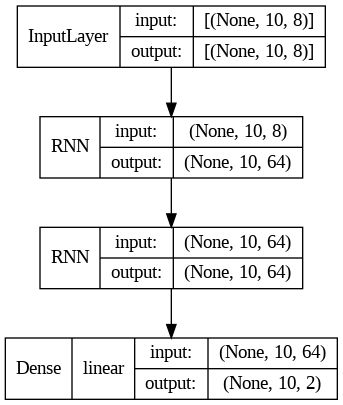

In [15]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False, show_layer_activations=True)

In [ ]:
# elu ICRNN with t_final = 0.005
# MSE loss 4.7460e-04
# model.save('/content/drive/MyDrive/MPC/model28.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model28.h5', custom_objects={"MyRNNCell": MyRNNCell})

# RNN model with tanh with t_final = 0.005
# MSE loss 2.7492e-05
# model.save('/content/drive/MyDrive/MPC/model26.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model26.h5')

# LSTM model with tanh with t_final = 0.005
# MSE loss 1.7523e-06
# model.save('/content/drive/MyDrive/MPC/model27.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model27.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
from tensorflow.python.framework.convert_to_constants import  convert_variables_to_constants_v2_as_graph

def get_flops(model):
    concrete = tf.function(lambda inputs: model(inputs))
    concrete_func = concrete.get_concrete_function(
        [tf.TensorSpec([1, *inputs.shape[1:]]) for inputs in model.inputs])
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(concrete_func, lower_control_flow=False)
    with tf.Graph().as_default() as graph:
        tf.graph_util.import_graph_def(graph_def, name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd="op", options=opts)
        return flops.total_float_ops

print("The FLOPs is:{}".format(get_flops(model)) ,flush=True )

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


The FLOPs is:79892


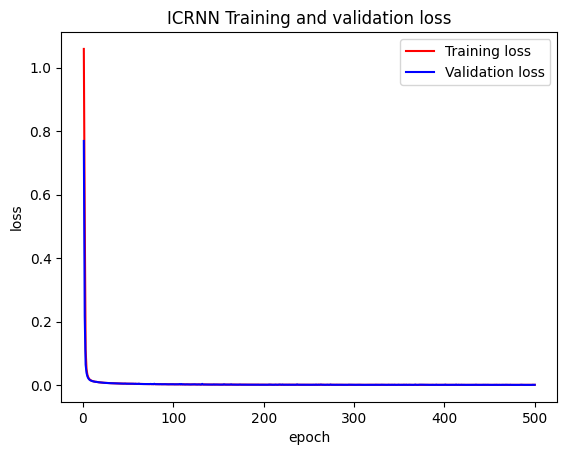

In [17]:
# plot training and validation losses against epochs

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('ICRNN Training and validation loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

<ipython-input-18-9998cc70c050>:12: RuntimeWarning: invalid value encountered in sqrt
  sqrt = np.sqrt(-2688000 * i**2 + 15772800000)


116/116 [==============================] - 1s 4ms/step
(3706, 10, 2)


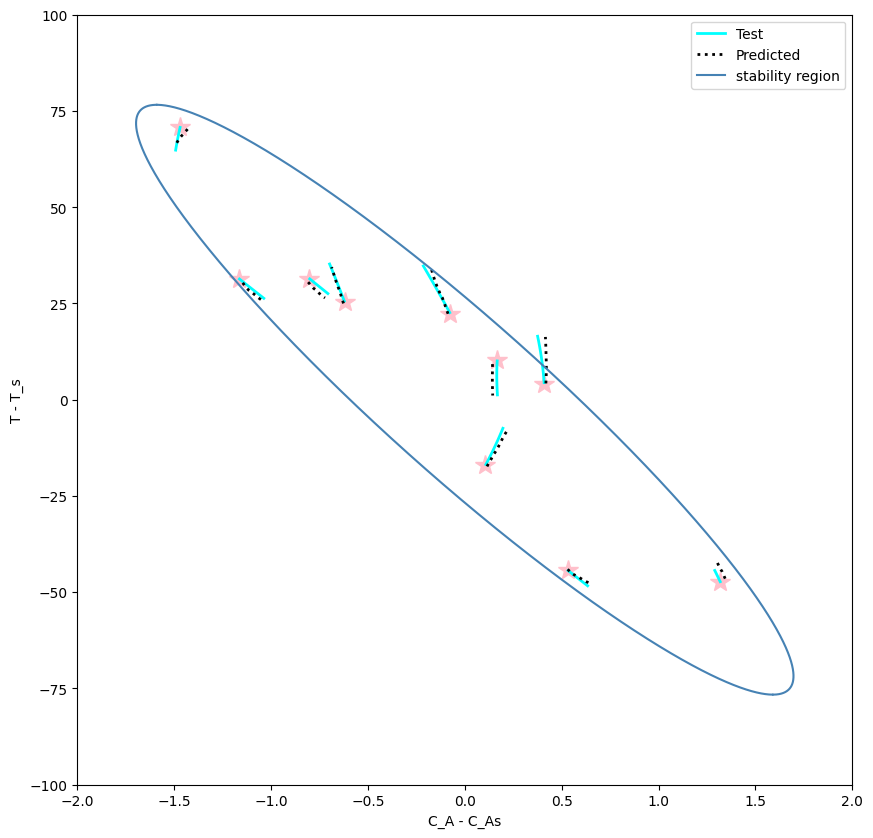

In [18]:
"""
    equation for the stability ellipse is 1060x^2 + 44xy + 0.52y^2 - 372 = 0
"""
# prepare x and y coordinates for plotting the stability region
y = np.linspace(-100, 100, 100000, endpoint=True)

x_upper = list()
x_lower = list()
y_plot = list()

for i in y:
    sqrt = np.sqrt(-2688000 * i**2 + 15772800000)
    if sqrt >= 0:
        y_plot.append(i)
        x_upper.append((-4400 * i + sqrt) / 212000)
        x_lower.append((-4400 * i - sqrt) / 212000)
        pass
    pass


plt.figure(figsize=(10,10))

# # plot the first 10 samples and their trajectories
y_predict = model.predict(X_test)
print(y_predict.shape)

y_predict = y_predict.reshape(-1,2)
y_predict = scaler_y.inverse_transform(y_predict)
y_predict = y_predict.reshape(-1,num_step,2)

X_plot = X_test.reshape(-1,num_dims)
X_plot = scaler_X.inverse_transform(X_plot)
X_plot = X_plot.reshape(-1,num_step,num_dims)

for i in range(10):
    if i == 0:  # only add label to 1 data point
        plt.plot(X_plot[i, 0, 1], X_plot[i, 0, 0], marker="*", markersize=15, color='pink')
        plt.plot(y_test[i, :, 1], y_test[i, :, 0], color='cyan', lw=2, label='Test')
        plt.plot(y_predict[i, :, 1], y_predict[i, :, 0], color='black', lw=2, ls=':', label='Predicted')
    else:
        plt.plot(X_plot[i, 0, 1], X_plot[i, 0, 0], marker="*", markersize=15, color='pink')
        plt.plot(y_test[i, :, 1], y_test[i, :, 0], color='cyan', lw=2)
        plt.plot(y_predict[i, :, 1], y_predict[i, :, 0], color='black', lw=2, ls=':')

# plot stability region
plt.plot(x_lower, y_plot, color='steelblue', label='stability region')
plt.plot(x_upper, y_plot, color='steelblue')
plt.ylim([-100, 100])
plt.xlim([-2, 2])

plt.xlabel("C_A - C_As")
plt.ylabel("T - T_s")
plt.legend()
plt.show()


In [19]:
print(y_predict[8, :, 0])
print(y_test[8, :, 0])

[70.28563  69.89617  69.53253  68.99037  68.56031  68.088936 67.58452
 67.1128   66.71054  66.38349 ]
[70.72561539 70.07921788 69.43025205 68.77887103 68.12522131 67.46944305
 66.81167038 66.15203175 65.49065012 64.82764332]
